In [2]:
import os
import sqlite3

import numpy as np
import pandas as pd

db_path = os.path.join(os.path.dirname("__file__"), "..", "..", "data", "ufc.db")

In [3]:
query = """
WITH cte1 AS (
    SELECT
        ufcstats_bouts.id AS bout_id,
        event_id,
        date,
        bout_mapping.fightoddsio_id AS fightoddsio_bout_id,
        red_mapping.fightoddsio_id AS red_fighter_id,
        blue_mapping.fightoddsio_id AS blue_fighter_id,
        event_mapping.bestfightodds_id AS bestfightodds_event_id,
        red_mapping.bestfightodds_id AS bestfightodds_red_fighter_id,
        blue_mapping.bestfightodds_id AS bestfightodds_blue_fighter_id,
        CASE
            WHEN
                red_outcome = 'W' 
            THEN
                1 
            WHEN
                red_outcome = 'L' 
            THEN
                0 
            ELSE
                NULL 
        END
        AS red_win 
    FROM
        ufcstats_bouts 
        LEFT JOIN
            ufcstats_events 
            ON ufcstats_bouts.event_id = ufcstats_events.id 
        LEFT JOIN
            bout_mapping 
            ON ufcstats_bouts.id = bout_mapping.ufcstats_id 
        LEFT JOIN
            fighter_mapping AS red_mapping 
            ON ufcstats_bouts.red_fighter_id = red_mapping.ufcstats_id 
        LEFT JOIN
            fighter_mapping AS blue_mapping 
            ON ufcstats_bouts.blue_fighter_id = blue_mapping.ufcstats_id
        LEFT JOIN
            event_mapping
            ON ufcstats_events.id = event_mapping.ufcstats_id
    WHERE
        is_ufc_event = 1 
        AND date >= '2017-01-01' 
), 
cte2 AS (
    SELECT
        ROW_NUMBER() OVER (PARTITION BY bout_id 
    ORDER BY
        fightoddsio_moneyline_odds.rowid DESC) AS rn,
        bout_id AS fightoddsio_bout_id,
        fighter_1_id,
        fighter_2_id,
        fighter_1_odds_current,
        fighter_2_odds_current 
    FROM
        fightoddsio_moneyline_odds 
        LEFT JOIN
            fightoddsio_bouts 
            ON fightoddsio_moneyline_odds.bout_id = fightoddsio_bouts.id 
    WHERE
        sportsbook_id = 
        (
            SELECT
                id 
            FROM
                fightoddsio_sportsbooks 
            WHERE
                full_name = 'Bovada' 
        )
    ORDER BY
        fightoddsio_bouts.rowid ASC,
        fightoddsio_moneyline_odds.rowid ASC 
), 
cte3 AS (
    SELECT
        fightoddsio_bout_id,
        fighter_1_id,
        fighter_2_id,
        fighter_1_odds_current, fighter_2_odds_current 
    FROM
        cte2 
    WHERE
        rn = 1 
), 
cte4 AS (
    SELECT
        fightoddsio_bout_id,
        fighter_1_id AS fightoddsio_fighter_id,
        fighter_1_odds_current AS odds 
    FROM
        cte3
    UNION
    SELECT
        fightoddsio_bout_id,
        fighter_2_id AS fightoddsio_fighter_id,
        fighter_2_odds_current AS odds 
    FROM
        cte3
),
cte5 AS (
    SELECT
        ROW_NUMBER() OVER (PARTITION BY bout_id 
    ORDER BY
        fightoddsio_moneyline_odds.rowid DESC) AS rn,
        bout_id AS fightoddsio_bout_id,
        fighter_1_id,
        fighter_2_id,
        fighter_1_odds_current,
        fighter_2_odds_current 
    FROM
        fightoddsio_moneyline_odds 
        LEFT JOIN
            fightoddsio_bouts 
            ON fightoddsio_moneyline_odds.bout_id = fightoddsio_bouts.id 
    WHERE
        sportsbook_id = 
        (
            SELECT
                id 
            FROM
                fightoddsio_sportsbooks 
            WHERE
                full_name = 'Pinnacle Sports' 
        )
    ORDER BY
        fightoddsio_bouts.rowid ASC,
        fightoddsio_moneyline_odds.rowid ASC 
), 
cte6 AS (
    SELECT
        fightoddsio_bout_id,
        fighter_1_id,
        fighter_2_id,
        fighter_1_odds_current, fighter_2_odds_current 
    FROM
        cte5
    WHERE
        rn = 1 
), 
cte7 AS (
    SELECT
        fightoddsio_bout_id,
        fighter_1_id AS fightoddsio_fighter_id,
        fighter_1_odds_current AS odds 
    FROM
        cte6
    UNION
    SELECT
        fightoddsio_bout_id,
        fighter_2_id AS fightoddsio_fighter_id,
        fighter_2_odds_current AS odds 
    FROM
        cte6
),
cte8 AS (
    SELECT
        event_id,
        fighter_id,
        timestamp,
        ROW_NUMBER() OVER (
            PARTITION BY event_id, fighter_id
            ORDER BY timestamp DESC
        ) AS rn,
        odds
    FROM
        bestfightodds_moneyline_odds
    WHERE
        betsite = 'BetOnline'
),
cte9 AS (
    SELECT
        event_id,
        fighter_id,
        odds
    FROM
        cte8
    WHERE
        rn = 1
)
SELECT
    bout_id,
    cte1.event_id,
    date,
    CASE
        WHEN red_mapping1.odds IS NOT NULL AND blue_mapping1.odds IS NOT NULL THEN 'Bovada'
        WHEN red_mapping2.odds IS NOT NULL AND blue_mapping2.odds IS NOT NULL THEN 'Pinnacle Sports'
        ELSE 'BetOnline'
    END AS sportsbook,
    CASE
        WHEN red_mapping1.odds IS NOT NULL AND blue_mapping1.odds IS NOT NULL THEN red_mapping1.odds
        WHEN red_mapping2.odds IS NOT NULL AND blue_mapping2.odds IS NOT NULL THEN red_mapping2.odds
        ELSE red_mapping3.odds
    END AS red_odds,
    CASE
        WHEN blue_mapping1.odds IS NOT NULL AND red_mapping1.odds IS NOT NULL THEN blue_mapping1.odds
        WHEN blue_mapping2.odds IS NOT NULL AND red_mapping2.odds IS NOT NULL THEN blue_mapping2.odds
        ELSE blue_mapping3.odds
    END AS blue_odds,
    red_win
FROM
    cte1  
    LEFT JOIN
        cte4 AS red_mapping1 
        ON cte1.fightoddsio_bout_id = red_mapping1.fightoddsio_bout_id 
        AND cte1.red_fighter_id = red_mapping1.fightoddsio_fighter_id 
    LEFT JOIN
        cte4 AS blue_mapping1 
        ON cte1.fightoddsio_bout_id = blue_mapping1.fightoddsio_bout_id 
        AND cte1.blue_fighter_id = blue_mapping1.fightoddsio_fighter_id
    LEFT JOIN
        cte7 AS red_mapping2
        ON cte1.fightoddsio_bout_id = red_mapping2.fightoddsio_bout_id
        AND cte1.red_fighter_id = red_mapping2.fightoddsio_fighter_id
    LEFT JOIN
        cte7 AS blue_mapping2
        ON cte1.fightoddsio_bout_id = blue_mapping2.fightoddsio_bout_id
        AND cte1.blue_fighter_id = blue_mapping2.fightoddsio_fighter_id
    LEFT JOIN
        cte9 AS red_mapping3
        ON cte1.bestfightodds_event_id = red_mapping3.event_id
        AND cte1.bestfightodds_red_fighter_id = red_mapping3.fighter_id
    LEFT JOIN
        cte9 AS blue_mapping3
        ON cte1.bestfightodds_event_id = blue_mapping3.event_id
        AND cte1.bestfightodds_blue_fighter_id = blue_mapping3.fighter_id;
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(query, conn)
df

,bout_id,event_id,date,sportsbook,red_odds,blue_odds,red_win
0,c1356395d6b055d7,46effbd1135423c5,2017-01-15,Bovada,-110,-120,0.0
1,ae803440d778a12b,46effbd1135423c5,2017-01-15,Bovada,190,-240,0.0
2,3f7684492c9df05e,46effbd1135423c5,2017-01-15,Bovada,-160,130,1.0
3,53c3565ee1d3411a,46effbd1135423c5,2017-01-15,Bovada,145,-175,0.0
4,8156479490877d08,46effbd1135423c5,2017-01-15,Bovada,-170,140,1.0
...,...,...,...,...,...,...,...
3955,5238f6470d0557fb,72c9c2eadfc3277e,2024-12-14,Bovada,215,-260,0.0
3956,7b1bc4ff776f12c1,72c9c2eadfc3277e,2024-12-14,Bovada,-320,265,0.0
3957,1a635a5e4551e7d5,72c9c2eadfc3277e,2024-12-14,Bovada,-420,320,1.0
3958,7521015554088962,72c9c2eadfc3277e,2024-12-14,Bovada,175,-205,1.0


In [5]:
df["red_implied_prob"] = df["red_odds"].apply(lambda x: 100 / (x + 100) if x > 0 else -x / (-x + 100))
df["blue_implied_prob"] = df["blue_odds"].apply(lambda x: 100 / (x + 100) if x > 0 else -x / (-x + 100))
df["red_win_prob"] = df["red_implied_prob"] / (df["red_implied_prob"] + df["blue_implied_prob"])
df

,bout_id,event_id,date,sportsbook,red_odds,blue_odds,red_win,red_implied_prob,blue_implied_prob,red_win_prob
0,c1356395d6b055d7,46effbd1135423c5,2017-01-15,Bovada,-110,-120,0.0,0.523810,0.545455,0.489879
1,ae803440d778a12b,46effbd1135423c5,2017-01-15,Bovada,190,-240,0.0,0.344828,0.705882,0.328185
2,3f7684492c9df05e,46effbd1135423c5,2017-01-15,Bovada,-160,130,1.0,0.615385,0.434783,0.585987
3,53c3565ee1d3411a,46effbd1135423c5,2017-01-15,Bovada,145,-175,0.0,0.408163,0.636364,0.390764
4,8156479490877d08,46effbd1135423c5,2017-01-15,Bovada,-170,140,1.0,0.629630,0.416667,0.601770
...,...,...,...,...,...,...,...,...,...,...
3955,5238f6470d0557fb,72c9c2eadfc3277e,2024-12-14,Bovada,215,-260,0.0,0.317460,0.722222,0.305344
3956,7b1bc4ff776f12c1,72c9c2eadfc3277e,2024-12-14,Bovada,-320,265,0.0,0.761905,0.273973,0.735516
3957,1a635a5e4551e7d5,72c9c2eadfc3277e,2024-12-14,Bovada,-420,320,1.0,0.807692,0.238095,0.772329
3958,7521015554088962,72c9c2eadfc3277e,2024-12-14,Bovada,175,-205,1.0,0.363636,0.672131,0.351079


In [6]:
from sklearn.metrics import log_loss
from sklearn.calibration import CalibrationDisplay

subset = df.loc[df["red_win"].notnull()]
log_loss(subset["red_win"], subset["red_win_prob"])

0.6096262473423532

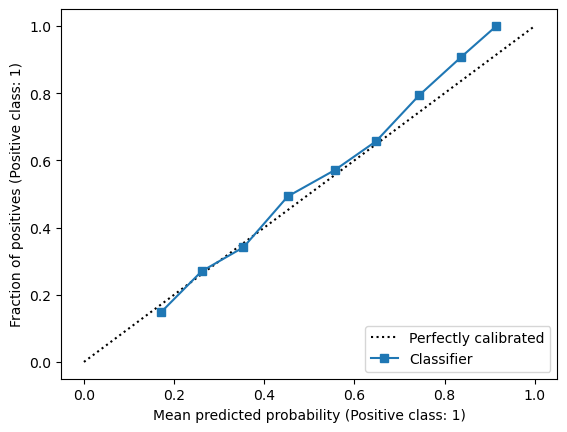

In [9]:
disp = CalibrationDisplay.from_predictions(
    subset["red_win"], subset["red_win_prob"], n_bins=10, strategy="uniform"
)